<a href="https://colab.research.google.com/github/srijitcnair/StockPricePredictionLSTM/blob/master/StockPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 38kB/s 
     |████████████████████████████████| 450kB 47.9MB/s 
     |████████████████████████████████| 3.8MB 48.2MB/s 
ERROR: tensorflow 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 1.15.0 has requirement tensorflow-estimator==1.15.1, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [1390]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import pandas as pd
from os import path

import pandas_datareader as dr
import matplotlib.pyplot as plt
tf.__version__

'2.0.0'

In [1391]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
rootDataFolder = "/content/drive/My Drive/Colab Notebooks/StockLSTMData/"

Mounted at /content/drive


In [0]:
sp500MemberListFile = rootDataFolder+'sp500_constituents.csv'
sp500MemberListFundamentalFile = rootDataFolder+'sp500_constituents_financials.csv'
sp500PickleLocation = rootDataFolder+'sp500data.pkl'
symbolPriceDataLocation = rootDataFolder+'symbol/'

In [0]:
def getDailyPrice(ticker, start, end):
    print('Fetching data for {}'.format(ticker))
    df= dr.get_data_yahoo([ticker], start, end)
    df.columns = df.columns.droplevel(1)
    #df.reset_index(inplace=True)    
    return df

In [0]:
def getPriceForIndex(ticker, start,end):
    return getDailyPrice(ticker,start,end)['Adj Close']

In [0]:
def computeMA(df, column, period):
  ma = df[column].rolling(window=period).mean()
  
  for i in range(period):
    ma[i:period] = np.mean(df[column][0:i+1])
  return ma

In [0]:
def computeBB(df, column, period=20):
  sma = df[column].rolling(window=period).mean()
  std = df[column].rolling(window=period).std()
  for i in range(period):
    sma[i:period] = np.mean(df[column][0:i+1])
    std[i:period] = np.std(df[column][0:i+1])

  upper_band = sma + 2 * std
  lower_band = sma - 2 * std
  width = 4*std
  return (upper_band, lower_band, width, sma)


In [0]:
def getPriceFeaturesForTicker(ticker,start,end):
  tickerPrice = getDailyPrice(ticker,start,end)

  #tickerPrice['body'] = tickerPrice['Close']-tickerPrice['Open']
  #tickerPrice['pct_change'] = tickerPrice['Adj Close'].pct_change()
  #tickerPrice['direction'] = np.where(tickerPrice['pct_change'] > 0, 1, 0)
  tickerPrice['range'] = tickerPrice['High']-tickerPrice['Low']
  #tickerPrice['Price_SMA_20'] = computeMA(tickerPrice, 'Adj Close', 20)
  tickerPrice['Price_SMA_5'] = computeMA(tickerPrice, 'Adj Close', 5)
  #tickerPrice['Volume_SMA_20'] = computeMA(tickerPrice, 'Volume', 20)
  tickerPrice['Volume_SMA_5'] = computeMA(tickerPrice, 'Volume', 5)

  #(_, _, bb_width,_) = computeBB(tickerPrice, 'Adj Close')
  #tickerPrice['BB_width']=bb_width

  indicesToAdd = ['^GSPC']#,'^VIX']

  for indice in indicesToAdd:
      indicePrice = getPriceForIndex(indice,start, end)
      commonDates = tickerPrice.index.intersection(indicePrice.index)
      tickerPrice = tickerPrice.loc[commonDates]
      tickerPrice[indice] = indicePrice.loc[commonDates]
      #tickerPrice[indice+'_SMA_5'] = computeMA(tickerPrice, indice, 5)

  tickerPrice.drop(['High','Low','Open','Close'], axis=1, inplace=True)
  tickerPrice.reset_index(inplace=True) 

  print(f'The columns being returned are {tickerPrice.columns}')
  return tickerPrice


In [0]:
#print(getPriceFeaturesForTicker('AAPL','01/01/2019','01/31/2019').columns)


In [0]:
def readSavedPriceData(ticker):
    return pd.read_pickle('{}{}.pkl'.format(symbolPriceDataLocation, ticker))

In [0]:
def downloadPriceForTickers(tickers, start, end):
    successCount = 0
    for ticker in tickers:
        try:
            getPriceFeaturesForTicker(ticker, start, end).to_pickle('{}{}.pkl'.format(symbolPriceDataLocation, ticker))
            successCount += 1
        except Exception as e:
            print('Error {} for symbol {}'.format(e, ticker))

    print('Successfully retrieved data for {} stocks'.format(successCount))

In [1400]:
#getDailyPrice('AAPL','01/01/2019','12/31/2019')
start_date = '01/01/2016'
end_date = '12/31/2019'
train_end_date = '06/01/2019'
valid_end_date = '10/01/2019'
ticker = 'GOOG'
num_lookback_days = 5
target_column = 'Adj Close'
downloadPriceForTickers([ticker],start_date,end_date)
data = readSavedPriceData(ticker)

Fetching data for GOOG
Fetching data for ^GSPC
The columns being returned are Index(['Date', 'Volume', 'Adj Close', 'range', 'Price_SMA_5', 'Volume_SMA_5',
       '^GSPC'],
      dtype='object', name='Attributes')
Successfully retrieved data for 1 stocks


In [0]:
def applyPCA(ticker_data):
  pca = PCA(0.95)
  pca.fit(ticker_data)
  print(f'Features picked by PCA: {pca.n_components_}')
  return pca

In [0]:
def preprocessAndSplitData(ticker, target_column, train_date_limit, validation_date_limit, sequence_length):
  ticker_data = readSavedPriceData(ticker)
  
  t = ticker_data[target_column]
  ticker_data.drop(labels=[target_column], axis=1,inplace = True)
  ticker_data.insert(0, target_column, t)

  scaler = MinMaxScaler(feature_range=(0,1))

  train_data = ticker_data[ticker_data['Date']<train_date_limit].copy()
  train_data.drop('Date',axis=1, inplace=True)
  train_data = scaler.fit_transform(train_data)
  train_data_y = train_data[:,0]
  train_data_x = train_data[:, 1:]
  #pca = applyPCA(train_data_x)
  #train_data_x = pca.transform(train_data_x)

  valid_data = ticker_data[(ticker_data['Date']>=train_date_limit) & (ticker_data['Date']<validation_date_limit)].copy()
  valid_data.drop('Date',axis=1, inplace=True)
  valid_data = scaler.transform(valid_data)
  valid_data_y = valid_data[:,0]
  valid_data_x = valid_data[:, 1:]
  #valid_data_x = pca.transform(valid_data_x)

  test_data = ticker_data[ticker_data['Date']>=validation_date_limit].copy()
  test_data.drop('Date',axis=1, inplace=True)
  test_data = scaler.transform(test_data)
  test_data_y = test_data[:,0]
  test_data_x = test_data[:, 1:]
  #test_data_x = pca.transform(test_data_x)

  X_train = []
  Y_train = []
  for i in range(sequence_length,train_data_x.shape[0]):
    X_train.append(np.array(train_data_x[i-sequence_length:i]))
    Y_train.append(train_data_y[i])

  X_valid = []
  Y_valid = []
  for i in range(sequence_length,valid_data_x.shape[0]):
    X_valid.append(np.array(valid_data_x[i-sequence_length:i]))
    Y_valid.append(valid_data_y[i])

  X_test = []
  Y_test = []
  for i in range(sequence_length,test_data_x.shape[0]):
    X_test.append(np.array(test_data_x[i-sequence_length:i]))
    Y_test.append(test_data_y[i])

  X_test = np.array(X_test)
  Y_test = np.array(Y_test)

  return (X_train, Y_train, X_valid, Y_valid, X_test, Y_test, scaler)


In [0]:

(X_train, Y_train, X_valid, Y_valid, X_test, Y_test, scaler) = preprocessAndSplitData(ticker,target_column,train_end_date, valid_end_date,num_lookback_days)

In [1404]:
print('{},{},{}'.format(len(X_train), len(X_train[0]),len(X_train[0][0])))
print(len(Y_train))
print('--------------------')
print('{},{},{}'.format(len(X_valid), len(X_valid[0]),len(X_valid[0][0])))
print(len(Y_valid))
print('--------------------')
print('{},{},{}'.format(len(X_test), len(X_test[0]),len(X_test[0][0])))
print(len(Y_test))
print('--------------------')

853,5,5
853
--------------------
79,5,5
79
--------------------
59,5,5
59
--------------------


In [0]:
train_data_batch = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
train_data_batch = train_data_batch.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_batch = tf.data.Dataset.from_tensor_slices((X_valid, Y_valid))
val_data_batch = val_data_batch.batch(batch_size).repeat()

test_data_batch = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_data_batch = test_data_batch.batch(batch_size).repeat()

num_features = len(X_train[0][0])
batch_size = 100
buffer_size = 10000


In [0]:
model = Sequential(
    [
      Bidirectional(LSTM(units=256, return_sequences=True)),      
      Bidirectional(LSTM(units=128)),
      Dense(units=64, activation='relu'),
      Dropout(0.5),
      Dense(units=1, activation='relu')
    ]
)

model.build(input_shape=[batch_size, num_lookback_days,num_features])

#model.add(Dropout(0.2))

#model.add(LSTM(units=128,return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(units=5))
#model.add(Dropout(0.2))

#model.add(LSTM(units=24, activation='relu'))
#model.add(Dropout(0.4))

#model.add(LSTM(units=128, activation='relu'))
#model.add(Dropout(0.4))

#model.add(Dense(units=32, activation='relu'))



In [0]:
#optimizer = tf.keras.optimizers.RMSprop(0.001)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.MeanSquaredError()
#loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss)

In [1408]:
model.summary()


Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_20 (Bidirectio multiple                  536576    
_________________________________________________________________
bidirectional_21 (Bidirectio multiple                  656384    
_________________________________________________________________
dense_170 (Dense)            multiple                  16448     
_________________________________________________________________
dropout_192 (Dropout)        multiple                  0         
_________________________________________________________________
dense_171 (Dense)            multiple                  65        
Total params: 1,209,473
Trainable params: 1,209,473
Non-trainable params: 0
_________________________________________________________________


In [1409]:
for x, y in test_data_batch.take(1):
  print(x.shape)
  print(model.predict(x).shape)

(59, 5, 5)
(59, 1)


In [1410]:
epochs = 100
evaluation_interval = 50
es_callback = EarlyStopping(monitor='val_loss', patience=10)
model.fit(train_data_batch, epochs=epochs,
          steps_per_epoch=evaluation_interval,
          validation_data=val_data_batch,          
          validation_steps=evaluation_interval,callbacks=[es_callback])

Train for 50 steps, validate for 50 steps
Epoch 1/100
50/50 [==============================] - 29s 575ms/step - loss: 0.0305 - val_loss: 0.0034
Epoch 2/100
50/50 [==============================] - 12s 233ms/step - loss: 0.0135 - val_loss: 0.0032
Epoch 3/100
50/50 [==============================] - 12s 232ms/step - loss: 0.0139 - val_loss: 0.0043
Epoch 4/100
50/50 [==============================] - 12s 231ms/step - loss: 0.0125 - val_loss: 0.0036
Epoch 5/100
50/50 [==============================] - 12s 236ms/step - loss: 0.0113 - val_loss: 0.0019
Epoch 6/100
50/50 [==============================] - 12s 233ms/step - loss: 0.0109 - val_loss: 0.0024
Epoch 7/100
50/50 [==============================] - 12s 232ms/step - loss: 0.0098 - val_loss: 0.0022
Epoch 8/100
50/50 [==============================] - 12s 231ms/step - loss: 0.0096 - val_loss: 0.0018
Epoch 9/100
50/50 [==============================] - 11s 210ms/step - loss: 0.0089 - val_loss: 0.0030
Epoch 10/100
50/50 [====================

In [1411]:
Y_pred = model.predict(X_test) * (1/scaler.scale_[0])
Y_pred[0:10]

array([[538.12866],
       [534.9872 ],
       [538.6136 ],
       [538.1099 ],
       [538.3141 ],
       [542.35657],
       [539.4257 ],
       [548.5351 ],
       [557.8157 ],
       [562.656  ]], dtype=float32)

In [1412]:
Y_test_scaled = Y_test.reshape(-1, 1) * (1/scaler.scale_[0])
Y_test_scaled[0:10]

array([[520.86999512],
       [534.05004883],
       [540.41003418],
       [547.18994141],
       [548.88000488],
       [574.75      ],
       [575.38000488],
       [584.80993652],
       [577.22998047],
       [577.89001465]])

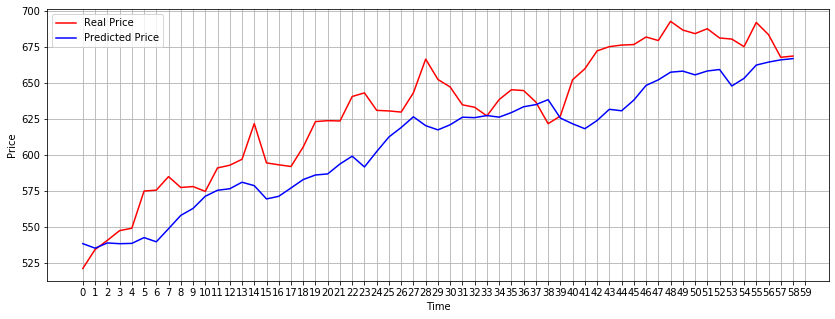

In [1413]:
fig = plt.figure(figsize=(14,5))
plt.plot(Y_test_scaled, color = 'red', label = 'Real Price')
plt.plot(Y_pred, color = 'blue', label = 'Predicted Price')

ax = fig.gca()
ax.set_xticks(np.arange(0, 60, 1))
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()